In [1]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List

dataset = pd.read_csv('data/synchronized-eeg.csv',
                      parse_dates=['indra_time'],
                      index_col='indra_time')
# convert to arrays from strings
dataset.raw_values = dataset.raw_values.map(json.loads)

Populating the interactive namespace from numpy and matplotlib


# 1. EEG

Neurons produce electrical activity in the brain.

If we zoom out far enough (and, for our purposes, we must), these neuronal firings appear most clearly as patterns of constructive or destructive interference. They are typically low-frequency waves, 0.5Hz-70Hz.

But, don't take my word for it. Let's open up a signal from our corpus.

Here's 512 readings, or one second, of the 30,000 seconds in our dataset. Let's take the 100th reading in our dataset:

In [2]:
dataset.raw_values[100]   # raw_values from line 102 in excel file

100    177
100     96
100    291
100    299
100    220
100    379
100    356
100    364
100    505
100    348
100    264
100    280
100     44
100     87
100    277
100    290
100    528
100    680
100    664
100    825
100    781
100    521
100    498
100    357
100    203
100    281
100    130
100     36
100     92
100   -138
      ... 
100    712
100    721
100    434
100    401
100    290
100     76
100    162
100     49
100    -61
100     35
100   -158
100   -353
100   -305
100   -422
100   -394
100   -262
100   -370
100   -317
100   -250
100   -500
100   -507
100   -456
100   -535
100   -331
100   -270
100   -292
100    -81
100   -118
100   -258
100   -108
Name: raw_values, Length: 512, dtype: object

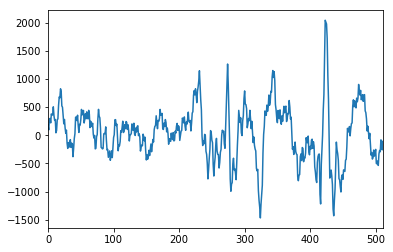

In [3]:
pd.Series(dataset.raw_values[100].values).plot()

This is *time-domain* data. It represents voltages over time.

We can turn this into *frequency-domain* data using an [FFT](https://www.youtube.com/watch?v=iWZNTM139xQ). (You don't need to understand how this works right now). We'll produce what's called a *power spectrum*.


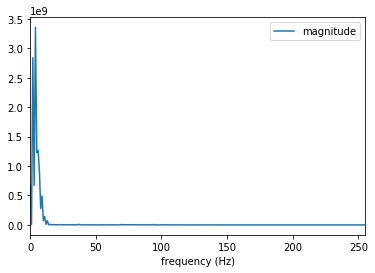

In [4]:
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

ps = to_power_spectrum(dataset.raw_values[1000])
ps.plot(x='frequency (Hz)')

Now, we can see some low-frequency data, toward the left side of the graph

Let's do a "band-pass" between 0.5Hz and 20Hz, effectively "zooming in" or "cropping" to these frequencies.

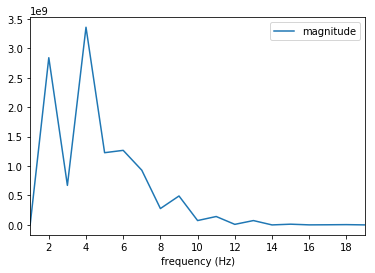

In [5]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

Now, here's the problem: There's a bunch of other crap in the signal, too!

For example, along with the EEG signal we just saw, there's also a bunch of EMG (electromyographic) data, which is produced by the muscles in your face, or from moving your eyes!

Most of this signal will be in the *50Hz to 150Hz* range. Eyeblinks will cause big spikes in this frequency band.

### TODO
Bandpass to the EMG frequency bands, and plot them. If you want, see if you can find any readings with big spikes in this band!

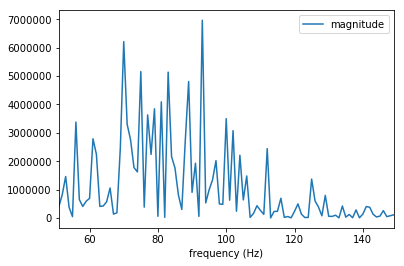

In [6]:
bandpass(ps, 50, 150).plot(x='frequency (Hz)')

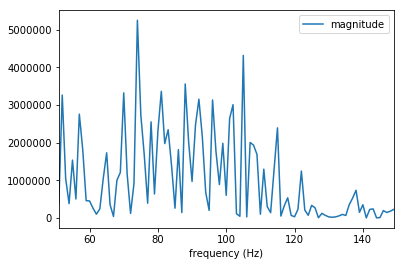

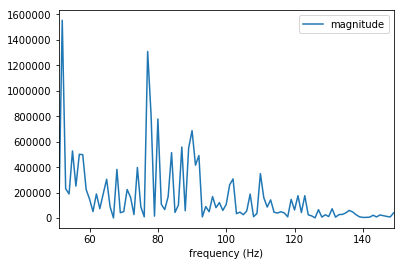

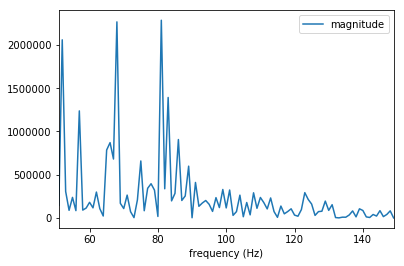

In [9]:
# looking at some other spectra

dict = {}
for i in range(5000, 20000, 5000):
    dict[i] = to_power_spectrum(dataset.raw_values[i])
    bandpass(dict[i], 50, 150).plot(x='frequency (Hz)')

We might also see ECG (electrocardiographic) signals, from the heart.

We'll even see background radiation from the electrical system! Here in North America, we'll see a 60Hz spike no matter what we do.

# 2. Classification

We can go crazy trying to filter all of these artifacts (and many have). 

However, we are at Berkeley, so we will take a lazy (computational) view.

We will shift our perspective in two ways, and in the end, we will not feel obligated to filter artifacts:

1. *The electromagnet is a general-purpose **biosensor***. We are sensing a multitude of human activity, including, but not limited to, EEG.

2. *Our machine learning will handle the artifacts*. If some artifacts really are artifacts (i.e., they are not informative with respect to our problem domain), then our ML will simply learn to ignore them.

`<OPTIONAL NOTE>`

These two "perspective shifts" are tightly intertwined. If you are up for it, try using the second as a lens for viewing the first. Our assumptions about EEG melt away, and we are left only with a classification problem and a signal (and the assumptions [built into those infrastructures](https://mitpress.mit.edu/books/raw-data-oxymoron) ;) ). 

We do not need to make specific commitments about what mechanisms produce the effects we are interested in. Thus, we avoid all hard epistemolgical questions (and complaints)! We are also free to discover signals that might come from unexpected places.  

If this is over your head, just remember this: If we're trying to classify interest (say), perhaps an unconscious eyebrow raise is our key signal. It would be a shame if we filtered it out, in our myopic quest for a "clean" EEG signal!

`</OPTIONAL NOTE>`

Fine, so what kind of classifier will just handle the artifacts for us?
I know, I know, you're probably thinking of neural networks. [That's an option](https://arxiv.org/pdf/1611.08024.pdf).

But, for now, we will use something much simpler, and much easier to run on your laptop: [XGBoost](https://github.com/dmlc/xgboost). You can [read up](https://xgboost.readthedocs.io/en/latest/model.html) on XGBoost on your own time, but like the FFT, you don't need to know how it works right now.

In fact, you don't even need to know what machine learning is. I will just show you an example of how to use XGBoost, and we can go from there.

First, let's make a plain, *untrained* classifier.

In [58]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',  # log regr for bin classif, output probability
        seed=27)

clf = fresh_clf()


Right now, this classifier is fresh to the world. It has seen no evil, heard no evil...

The "learning" part happens when our  classifier is *trained*, or *fit*, using examples. These examples have *labels*, and *features*. Our classifier will study the relationship between features and labels, so that in the future, it can map features to labels (more on this in a second).

Our **features** here are pretty clear: electromagnetic signals, our power spectra.

Our **labels** can really be anything, but for now, let's pick stuff that's easy from the existing dataset: People who are doing math, and people who are doing nothing. 

In [59]:
# All the readings during the "relax" task
relax = dataset[(dataset.label == 'relax') & 
                (dataset.id == 1) ]
# All the readings taken during "math" tasks
# (Math tasks were labeled math1...math12 -
#  `math\d` is a "regular expression," or RegEx)
math = dataset[(dataset.label.str.match(r'math\d')) &
               (dataset.id == 1) ]

len(relax), len(math)

(30, 30)

Now, we'll go about preparing our data for the classifier. 

Since our features are the power spectra, we should assemble a big collection of power spectra - and nothing else.

In [60]:
def to_features (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum)
    return np.array([row.magnitude.values for row in power_specs])

Now we can make a big list of all features, with their labels removed.

In [61]:
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

In [62]:
relax_features.shape

(30, 256)

However, for each of these features, we will need corresponding labels.

Since our machine has no semantic knowledge of what these labels "mean," we will simply refer to them as 0 and 1, respectively.

In [63]:
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

What we are left with are two matrices (numpy arrays): one of the features, and one of the labels. The labels matrix is one-dimensional.

The features matrix can be have another dimension of any length. However, along its first dimension, it must be the same shape as the labels, so that the two align (every feature has a label).

So, here, our labels are n x 1, and our features are 256 x n. (Our sampling rate is 512, producing power spectra of size 256.)

In [64]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((60, 256), (60,))

By convention, we refer to the features matrix as `X` and the labels matrix as `y`. 

(I know, I know. Mathematicians have no idea how to name a variable. But, the variable names `X` and `y` are so common in literature and documentation, I feel you should be familiar with them. And thus I perpetuate the problem...)

In [65]:
X = features
y = labels

Now, we can finally train our classifier!

In [66]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

Great, we trained it! So, how does it do?

Aha, but if we've used all of our data to trian the classifier, what can we use to *test* the classifier?

We could test the classifier on the exact same stuff we trained it on, but *WE SHOULD NEVER DO THIS!!! NEVER TEST ON THE TRAIN SET!!* 

Why? The answer has to do with a concept called *overfitting*. 

> A model *overfits* to its data when it explains the data it was trained on *so exactly* that it no longer generalizes to new, unseen data. 

For example, a model may memorize the data, including noise in the data, to produce perfect accuracy. Effectively, it will memorize the data! How useful will this memorization be in classifying data it's never seen before? Not very!

To get around this, we *split* the data into train and test sets.

In [67]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)

# (Remember, there's nothing "random" on a computer,
#  but, we do have *pseudo-*random number generators
#  (PRNGs) which are almost as good. If we fix the seed,
#  they will always generate the same sequence of numbers.
#  However, to someone who doesn't know the seeds, the
#  numbers look like white noise. Magic! You ever wonder
#  how garage door openers work? Research more
#  on your own time.)

Now we can train a *fresh* classifier on the train set,

In [68]:
clf = fresh_clf()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

and test on the test set!

In [69]:
clf.score(X_test, y_test)

0.90000000000000002

But XGBoost is even smarter than that. 

Oh yes, XGBoost is very smart. It can take some data, randomly split it into train and test sets, then see how well it does on the test set. It will use these results to tweak its parameters. Then, it can repeat this process a number of times, until it starts doing very well!


In [70]:
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

Now we'll now split the data into a *train* set (for which XGBoost will manage the train/test splitting), and a *validation* set, which we will use to see the results of XGBoost's efforts.

In [71]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

This `cvres` value is actually a DataFrame detailing each "tweaking" step XGBoost did in training the parameters. We can inspect the last few rows to see what it did right before it delievered the classifier to us.

(If you notice in the `xgb_cross_validate` method above, we specified an `early_stopping_rounds`. We keep tweaking parameters until the results are pretty high, or until we have tried for 100 rounds - whichever comes first).

In [72]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
96,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
97,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
98,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
99,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396


In [73]:
clf.score(X_validate, y_validate)

0.90000000000000002

## TODO

For how many rounds did XGBoost tweak our classifier, above, before stopping?

*There are 100 rows (see cvres.tail()), so XGBoost tweaked parameters until it hit the early stopping limit of 100.*

What is the estimated accuracy of our classifier at distinguishing between "math" and "relax" tasks, across all subjects?

*The classifier predicts the correct label with 90% accuracy. Note that a score of 0 is more significant than a score of 50; 50 is as good as random, but 0 is incorrectly classifying everything.*

## TODO

In this notebook, why did our classifier do as well as it did?

In answering this question, do research, and make educated guesses based on what you learn. Optionally make arguments based on any any evidence you can collect. 

There are no right or wrong answers here. Nor is there only one answer - there are potentially a number of possible explanations! 

Some questions I always ask myself whenever I come up with explanations:

- Could I test this theory? How?
- Are there any *other* explanations? Can I test those?
- Why might the current results be misleading?

Data from one person is likely to be more similar—in frequency distribution, amplitude, or some other measure—to other data collected from that same person. Here we've only tested on the subject with ID 1, so we haven't had to deal with classifying inter-person states. Below I try scoring on data from other IDs:

In [157]:
def get_score(identif, classif):
    relax_2 = dataset[(dataset.label == 'relax') & 
                (dataset.id == identif) ]
    math_2 = dataset[(dataset.label.str.match(r'math\d')) &
               (dataset.id == identif) ]
    relax_features_2 = to_features(relax_2)
    math_features_2 = to_features(math_2)
    features_2 = np.concatenate([relax_features_2, math_features_2])

    assert np.all( [ len(feat) == 256 for feat in features_2 ] )

    labels_2 = np.array([0 for feature in relax_features_2] \
                    + [1 for feature in math_features_2])
    assert len(labels_2) == len(features_2)
    assert labels_2[0] == 0
    assert labels_2[-1] == 1
    assert features_2.shape[0] == labels_2.shape[0]
    X_2 = features_2
    y_2 = labels_2
    score = classif.score(X_2, y_2)
    return score

In [158]:
ids = np.arange(1,31)
scores = []
scores.append(0.90000000000000002)

for i in range(2,31): 
    score = get_score(i, clf)
    scores.append(score)
    print('ID {} has score {}'.format(i, score))

ID 2 has score 0.2459016393442623
ID 3 has score 0.8135593220338984
ID 4 has score 0.6451612903225806
ID 5 has score 0.39344262295081966
ID 6 has score 0.45
ID 7 has score 0.45901639344262296
ID 8 has score 0.4666666666666667
ID 9 has score 0.5166666666666667
ID 10 has score 0.6
ID 11 has score 0.5901639344262295
ID 12 has score 0.55
ID 13 has score 0.15
ID 14 has score 0.45
ID 15 has score 0.5
ID 16 has score 0.4
ID 17 has score 0.6721311475409836
ID 18 has score 0.38333333333333336
ID 19 has score 0.90625
ID 20 has score 0.4166666666666667
ID 21 has score 0.4666666666666667
ID 22 has score 0.6
ID 23 has score 0.48333333333333334
ID 24 has score 0.4666666666666667
ID 25 has score 0.3
ID 26 has score 0.5409836065573771
ID 27 has score 0.48333333333333334
ID 28 has score 0.45
ID 29 has score 0.6833333333333333
ID 30 has score 0.4918032786885246


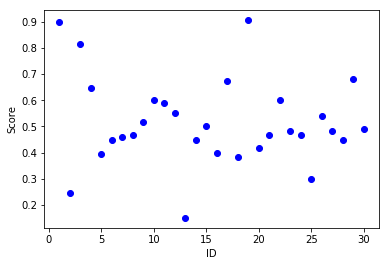

In [151]:
plt.plot(ids, scores, 'bo')
plt.xlabel('ID')
plt.ylabel('Score')
plt.show()

As expected, with a classifier trained on ID 1, other subjects' scores are generally much less than that of ID 1. The spread of scores is very interesting, though! I didn't expect the spread to be so wide.

Let's try making a classifier with ID 19, which had a very high score of 0.90625 when trained on ID 1, and see what happens when we do the same as above.

In [166]:
def make_classifier(identif):
    relax_2 = dataset[(dataset.label == 'relax') & 
                (dataset.id == identif) ]
    math_2 = dataset[(dataset.label.str.match(r'math\d')) &
               (dataset.id == identif) ]
    relax_features_2 = to_features(relax_2)
    math_features_2 = to_features(math_2)
    features_2 = np.concatenate([relax_features_2, math_features_2])

    assert np.all( [ len(feat) == 256 for feat in features_2 ] )

    labels_2 = np.array([0 for feature in relax_features_2] \
                    + [1 for feature in math_features_2])
    assert len(labels_2) == len(features_2)
    assert labels_2[0] == 0
    assert labels_2[-1] == 1
    assert features_2.shape[0] == labels_2.shape[0]
    X_2 = features_2
    y_2 = labels_2

    X_train_2, X_test_2, y_train_2, y_test_2 = sklearn.model_selection.train_test_split(
        X_2, y_2, 
        test_size=0.33, 
        random_state=42)

    clf_2 = fresh_clf()
    clf_2.fit(X_train_2, y_train_2)
    sco = clf.score(X_test_2, y_test_2)
    return (clf_2, sco)

clf_19, sco19 = make_classifier(19)
print(sco19)

0.909090909091


In [162]:
ids_2 = np.arange(1,31)
scores_2 = []

for i in range(1,31): 
    if i == 19:
        scores_2.append(sco19)
        continue
    score = get_score(i, clf_19)
    scores_2.append(score)
    print('ID {} has score {}'.format(i, score))

ID 1 has score 0.7666666666666667
ID 2 has score 0.21311475409836064
ID 3 has score 0.7457627118644068
ID 4 has score 0.7580645161290323
ID 5 has score 0.36065573770491804
ID 6 has score 0.4666666666666667
ID 7 has score 0.5409836065573771
ID 8 has score 0.6166666666666667
ID 9 has score 0.5833333333333334
ID 10 has score 0.5833333333333334
ID 11 has score 0.4918032786885246
ID 12 has score 0.6166666666666667
ID 13 has score 0.08333333333333333
ID 14 has score 0.35
ID 15 has score 0.5517241379310345
ID 16 has score 0.43333333333333335
ID 17 has score 0.6229508196721312
ID 18 has score 0.45
ID 20 has score 0.5
ID 21 has score 0.45
ID 22 has score 0.5666666666666667
ID 23 has score 0.5666666666666667
ID 24 has score 0.38333333333333336
ID 25 has score 0.38333333333333336
ID 26 has score 0.4918032786885246
ID 27 has score 0.5
ID 28 has score 0.38333333333333336
ID 29 has score 0.6333333333333333
ID 30 has score 0.5081967213114754


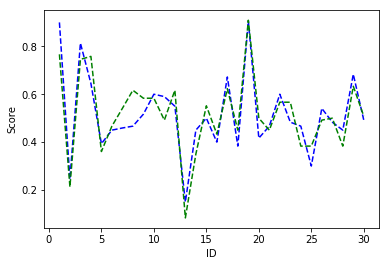

In [152]:
plt.plot(ids, scores, 'b--')
plt.plot(ids_2, scores_2, 'g--')
plt.xlabel('ID')
plt.ylabel('Score')
plt.show()

They're very similar! There are so many more experiments we could do along these lines; the first obvious one is trying this out with classifiers tested on IDS with scores around 0.7, 0.5, 0.3, and 0.

In [170]:
clf_dict = {}   # classifiers for all IDs
all_own_scores = []
for i in range(1, 31):
    clf_dict[i] = make_classifier(i)
    all_own_scores.append(clf_dict[i][1])
    print(i, clf_dict[i][1])   # print own score tested on classifier

1 0.9
2 0.285714285714
3 0.75
4 0.571428571429
5 0.333333333333
6 0.5
7 0.571428571429
8 0.45
9 0.5
10 0.6
11 0.47619047619
12 0.7
13 0.15
14 0.5
15 0.6
16 0.5
17 0.714285714286
18 0.25
19 0.909090909091
20 0.6
21 0.45
22 0.5
23 0.7
24 0.45
25 0.4
26 0.571428571429
27 0.45
28 0.4
29 0.575
30 0.571428571429


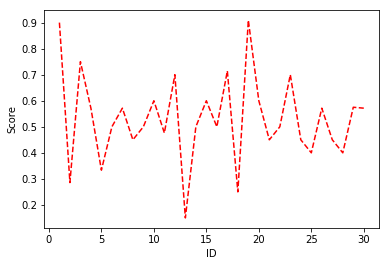

In [171]:
plt.plot(range(1,31), all_own_scores, 'r--')
plt.xlabel('ID')
plt.ylabel('Score')
plt.show()

Well... maybe the correct interpretation has been something else all along. We'd expect classifiers to have high scores when trained on themselves, but this is not the case. Since this graph is similar to the other two, it seems like given any classifier, including its own, some ID will have a similar score. To be continued...

Side note: I thought it was strange that both the xgboost and our cross-validating classifiers had the same score. This might be because we hit the early stopping limit, so our classifier didn't get to differentiate itself enough.

# Extra credit

Discover something new, and describe (or show) it below.

### Let's test Neurosky's eSense measures of Attention and Meditation.

We expect high Attention levels to correlate with the math task, high Meditation levels to correlate with the relax task, and vice versa. [Neurosky's docs](http://developer.neurosky.com/docs/doku.php?id=esenses_tm#esense_tm_meters) tell us that "Values from 80 to 100 are considered 'elevated', meaning they are strongly indicative of heightened levels of that eSense."

We'll also include all IDs to account for how much we're restricting our data.

In [90]:
relax2 = dataset[(dataset.label == 'relax')]
math2 = dataset[(dataset.label.str.match(r'math\d'))]

atten = dataset[(dataset.attention_esense >= 80)]
medit = dataset[(dataset.meditation_esense >= 80)]

len(relax2), len(math2), len(atten), len(medit)

(934, 936, 1472, 2846)

In [91]:
medRelax = dataset[(dataset.meditation_esense >= 80) & (dataset.label == 'relax')]
attMath = dataset[(dataset.attention_esense >= 80) & (dataset.label.str.match(r'math\d'))]

len(attMath), len(medRelax)

(74, 318)

OK, let's relax our threshold a little. From the docs again: "A value from 60 to 80 is considered 'slightly elevated', and may be interpreted as levels being possibly higher than normal (levels of Attention or Meditation that may be higher than normal for a given person)."

In [96]:
attRelax2 = dataset[(dataset.attention_esense >= 70) & (dataset.label == 'relax')]
medMath2 = dataset[(dataset.meditation_esense >= 70) & (dataset.label.str.match(r'math\d'))]
medRelax = dataset[(dataset.meditation_esense >= 70) & (dataset.label == 'relax')]
attMath = dataset[(dataset.attention_esense >= 70) & (dataset.label.str.match(r'math\d'))]

len(attRelax2), len(medMath2), len(medRelax), len(attMath)

(103, 230, 428, 140)

What's the {attention_esense, meditation_esense} distribution for {relax2, math2}?

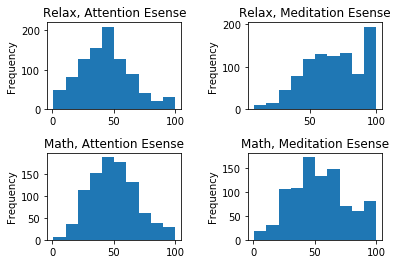

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=.5, wspace=.5)

relax2.attention_esense.plot.hist(title='Relax, Attention Esense',ax=axes[0,0])
relax2.meditation_esense.plot.hist(title='Relax, Meditation Esense',ax=axes[0,1])
math2.attention_esense.plot.hist(title='Math, Attention Esense',ax=axes[1,0])
math2.meditation_esense.plot.hist(title='Math, Meditation Esense',ax=axes[1,1])

We see what we'd expect in the meditation dimension (more counts for relax than math), but the results for attention are less well-defined. There's a greater spread for relax than math in attention, but the results for math aren't significant by Esense standards.

### Let's try making a classifier with the color task.

In [ ]:
dataset.label.unique()

In [ ]:
color = dataset[(dataset.label.str.match(r'colorRound\d-*\d*'))]
relax2 = dataset[(dataset.label == 'relax')]

In [ ]:
relax_features2 = to_features(relax2)
color_features = to_features(color)
features2 = np.concatenate([relax_features2, color_features])   
assert np.all( [ len(feat) == 256 for feat in features2 ] )

labels2 = np.array([ 0 for feature in relax_features2  ] \
                + [ 1 for feature in color_features ])
assert features2.shape[0] == labels2.shape[0]

X2 = features2
y2 = labels2

X2_train, X2_validate, y2_train, y2_validate = sklearn.model_selection.train_test_split(
    X2, y2, 
    test_size=0.33, 
    random_state=42)
clf2, cvres2 = xgb_cross_validate(X2_train, y2_train)
clf2.score(X2_validate, y2_validate)

Let's just use XGBoost alone:

In [ ]:
Xplain_train, Xplain_test, yplain_train, yplain_test = sklearn.model_selection.train_test_split(
    X2, y2, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)

clf_plain = fresh_clf()
clf_plain.fit(Xplain_train, yplain_train)
clf_plain.score(Xplain_test, yplain_test)

Same result. Why isn't there a difference between the two ways of classifying?

### Let's visualize some blinks.

In [10]:
blink = dataset[(dataset.label.str.match(r'blink5'))]
len(blink)

53

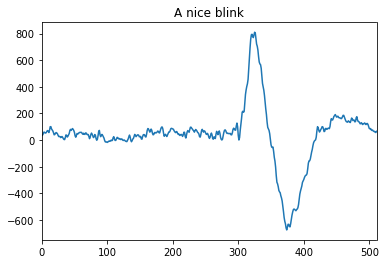

In [11]:
pd.Series(blink.raw_values[41].values).plot(title='A nice blink')

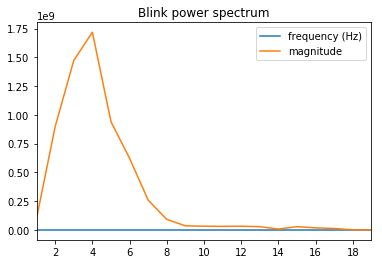

In [12]:
bandpass(to_power_spectrum(blink.raw_values[41]), 0, 20).plot(title='Blink power spectrum')

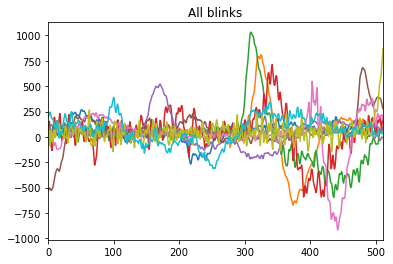

In [13]:
for i in range(40, 50):
    pd.Series(blink.raw_values[i].values).plot(title='All blinks')

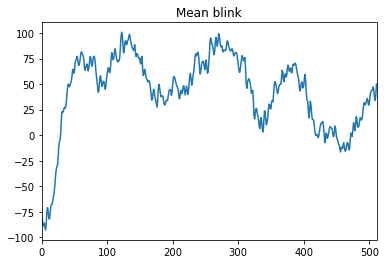

In [14]:
# average blink arrays
av = blink.raw_values[0].values
for i in range(len(blink)):
    av = np.add(av, blink.raw_values[i].values)
av /= len(blink)   
pd.Series(av).plot(title='Mean blink')

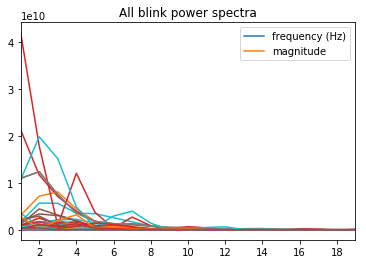

In [15]:
dfDict = {}
for i in range(len(blink)):
    dfDict[i] = bandpass(to_power_spectrum(blink.raw_values[i]), 0, 20)

ax = dfDict[0].plot(title='All blink power spectra')
for i in range(1,len(blink)):
    dfDict[i].plot(ax=ax, legend=False)

### Where were peaks in video-watching?

This part is not done yet. I'm trying to figure out how to combine different times for one subject, since it seems that each subject (from 16 to 30) has about 30 rows of video-watching data for video-ver2.

My goal is to bandpass for beta waves, comparing the spectra of subjects 19, 22, 27, 28, who have already seen the video, with other subjects.

In [86]:
videoData = dataset[dataset.label == 'video-ver2']
video_rawlist = videoData.raw_values
vd2 = dataset[(dataset.id == 30) & (dataset.label == 'video-ver2')]
vd2.shape

(30, 12)

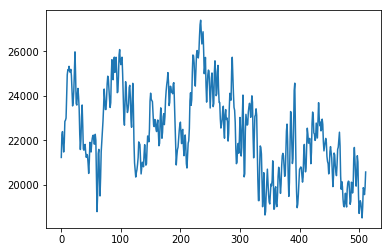

In [87]:
av = [0] * 512
for index, row in video_rawlist.iteritems():
    count = 0
    for i in row:
        av[count] += i
        count += 1  
    # average

plt.plot(av)

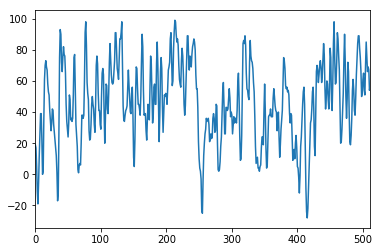

In [88]:
pd.Series(video_rawlist[2].values).plot()

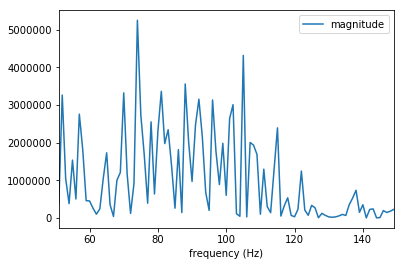

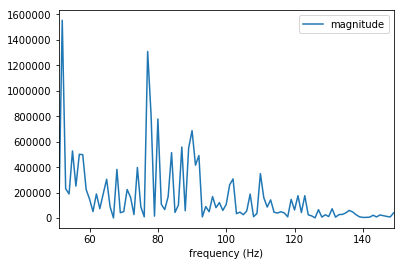

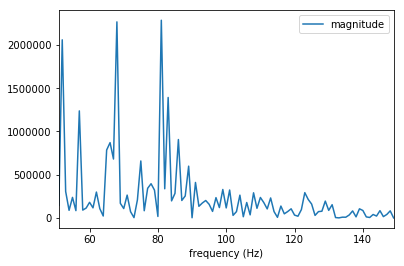

In [89]:
vid_dict = {}
for i in range(5000, 20000, 5000):
    vid_dict[i] = to_power_spectrum(dataset.raw_values[i])
    bandpass(vid_dict[i], 50, 150).plot(x='frequency (Hz)')